# Vehicle Routing Problem

In the Vehicle Routing Problem (VRP), the goal is to find optimal routes for multiple vehicles visiting a set of locations. (When there's only one vehicle, it reduces to the Traveling Salesman Problem.)

But what do we mean by "optimal routes" for a VRP? One answer is the routes with the least total distance. However, if there are no other constraints, the optimal solution is to assign just one vehicle to visit all locations, and find the shortest route for that vehicle. This is essentially the same problem as the TSP.

A better way to define optimal routes is to minimize the length of the longest single route among all vehicles. This is the right definition if the goal is to complete all deliveries as soon as possible. 

There are other ways of generalizing the VRP by adding constraints on the vehicles, including:
- Capacity constraints: the vehicles need to pick up items at each location they visit, but have a maximum carrying capacity.
- Time windows: each location must be visited within a specific time window.

The VRP example below finds optimal routes defined this way. 

In [22]:
# !python -m pip install --upgrade --user ortools
# !python -m pip show ortools

In [23]:
from __future__ import print_function
from ortools.linear_solver import pywraplp

In [24]:
# libraries
from __future__ import print_function
import pandas as pd
import numpy as np
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
import random 
import seaborn as sns
from matplotlib.ticker import MaxNLocator

#python -m pip install --upgrade --user ortools
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

## 1. Defining input and exploratory analysis

#### 1.1. Defining input parameters

In [25]:
# seed parameter
random.seed(3)
np.random.seed(7)
# 3,3 - some nodes are not covered
# 2,4 - no deliveries
# 3,7 - all deliveries

# Time horizon
Time_horizon=20 #weeks

# location info
location_number=21

# CHANGE HERE FOR SENSITIVITY ANALYSIS!
# Car info
car_park=6
car_capacity=[15, 15, 15, 15, 15, 15]
load_time=5
unload_time=5

# Depot info
depot_capacity=4

#### 1.2. Generating location coordinates and time windows

In [26]:
def generate_coordinates(n_pairs, x_min, x_max, y_min, y_max):
    coordinates=[]
    for i in range(0, n_pairs):
        x=np.random.randint(x_min, x_max) 
        y=np.random.randint(y_min, y_max)
        coordinates.append((x,y))
    return coordinates

def generate_timewindow(n_pairs):
    time=[]
    for i in range(0, n_pairs):
        x=np.random.randint(0, 60) 
        y=x+10
        time.append((x,y))
    return time

In [27]:
# parameters
coordinates=generate_coordinates(location_number,0,1000,0,1000)
time_window=generate_timewindow(location_number)

# Calculating base time for deliveries 
df = pd.DataFrame(coordinates, columns=['xcord', 'ycord'])
distance=(distance_matrix(df.values, df.values)/60).round() # calculate the average arrival time
distance_old=distance # storing a backup
df['Destination'] = df.index.values

#### 1.3. Location plot

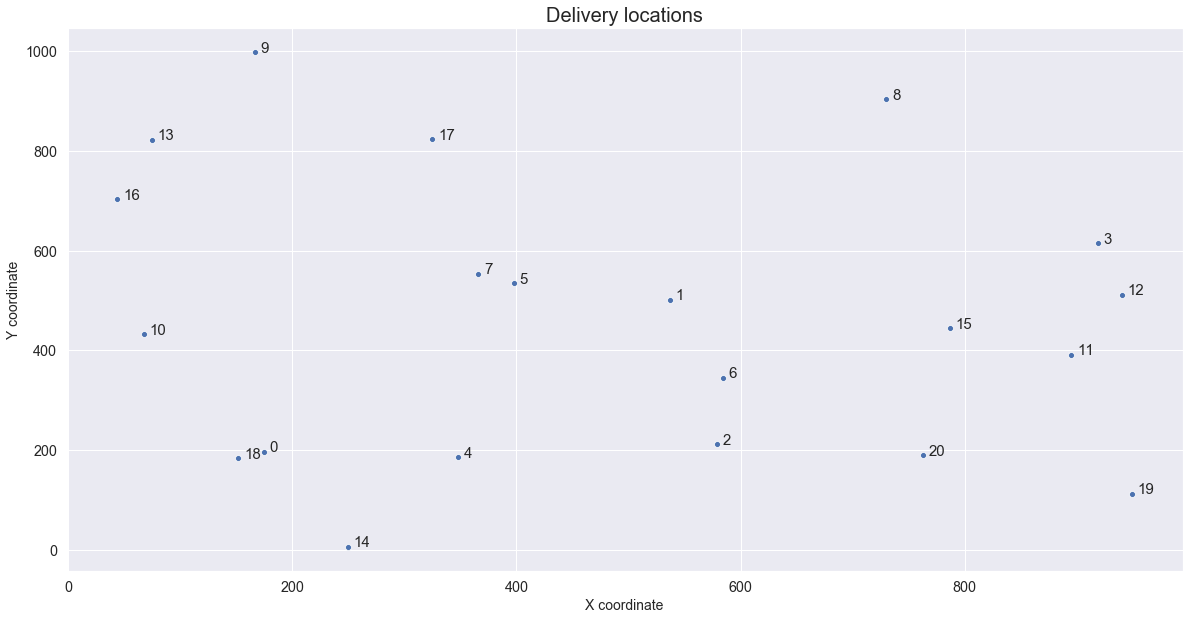

In [28]:
# Delivery locations
sns.set_style('darkgrid')
plt.figure(figsize=(20,10))
sns.set(font_scale=1.3)
p1 = sns.scatterplot(x="xcord", y="ycord", data=df) 

for line in range(0,df.shape[0]):
     p1.text(df.xcord[line]+5, 
             df.ycord[line],
             df.Destination[line], 
             horizontalalignment='left',
             size=15)
plt.title('Delivery locations',fontsize=20)
plt.xlabel('X coordinate',fontsize=14)
plt.ylabel('Y coordinate',fontsize=14)
plt.savefig(r"Delivery_locations.png")
plt.show()

#### 1.4. Time heatmap

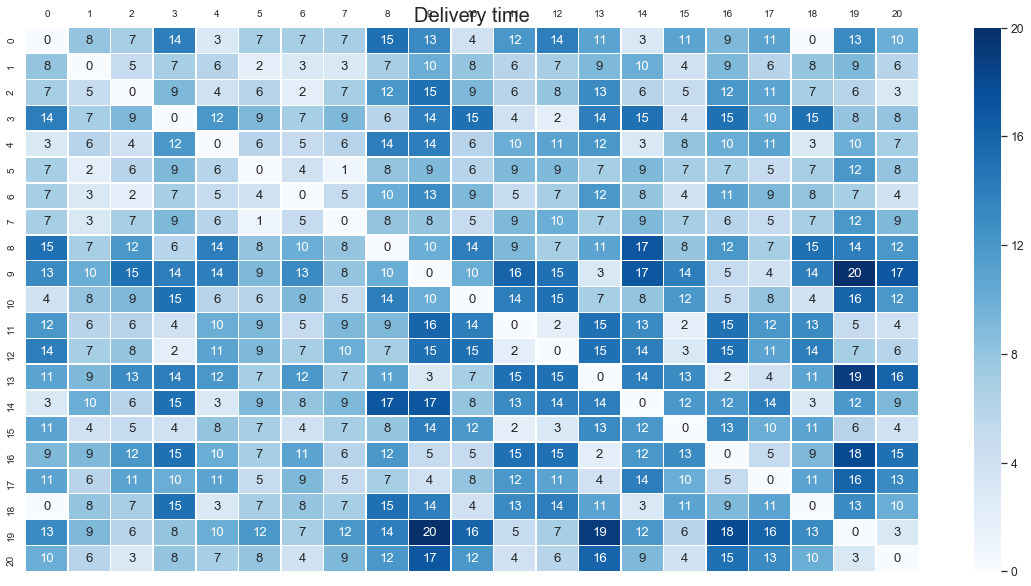

In [29]:
sns.set_style('darkgrid')
plt.figure(figsize=(20,10))
sns.set(font_scale=1.1)
ax = sns.heatmap(distance_old, annot=True, linewidths=.5, cmap="Blues")
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom=False, bottom=False, top=False, labeltop=True)
plt.title('Delivery time',fontsize=20)
plt.savefig(r"Delivery_time.png")
plt.show()

## 2. Modelling

#### 2.1. Preparing all required information 

In [30]:
def create_data_model():
    """Stores the data for the problem."""
    data = {}
    
    #-------------------------------------------------------------------------------
    # Simulating car crashes during the day    
    accidents = np.random.lognormal(1.1, .7, 1)[0]    # typically up to 10 accidents in the city. rarely up to 20. 
    for i in range(0, np.int16(accidents)):
        roads_blocked=np.random.randint(1, 5) 
        delay_time=np.random.lognormal(1.5, 1, 1)[0]  #delay typically lasts up to 60 minutes
        distance.flat[np.random.choice((location_number-1)*(location_number-1), roads_blocked, replace=False)] = np.int16(delay_time)
    np.fill_diagonal(distance, 0) 
    data['time_matrix'] = np.maximum(distance_old, distance) 

    #-------------------------------------------------------------------------------
    # time windows
    data['time_windows'] = time_window         
    
    #-------------------------------------------------------------------------------
    # number of goods to deliver
    data['demands'] = np.random.poisson(3, location_number)
    
    #-------------------------------------------------------------------------------
    # vehicle info:
    data['num_vehicles'] = car_park
    data['vehicle_capacities'] = car_capacity
    data['vehicle_load_time'] = load_time
    data['vehicle_unload_time'] = unload_time
    
    #-------------------------------------------------------------------------------
    # depot info
    data['depot_capacity'] = depot_capacity
    data['depot'] = 0
    return data

The data consists of:
- time_matrix: An array of travel times between locations.
- time_windows: An array of time windows for requested visits to the locations. 
- num_vehicles: The number of vehicles in the fleet.
- vehicle_load_time: The time required to load a vehicle.
- vehicle_unload_time: The time required to unload a vehicle.
- depot_capacity: The maximum number of vehicles that can load or unload at the same time.
- depot: The index of the depot, the location where all vehicles start and end their routes.


#### 2.2. Returning the simulation values

In [31]:
def print_solution(data, manager, routing, assignment):
    """Prints assignment on console."""

    # Display dropped nodes.
    dropped_nodes = 'Dropped nodes:'
    for node in range(routing.Size()):
        if routing.IsStart(node) or routing.IsEnd(node):
            continue
        if assignment.Value(routing.NextVar(node)) == node:
            dropped_nodes += ' {}'.format(manager.IndexToNode(node))
    print(dropped_nodes)
    
    # Display time
    time_dimension = routing.GetDimensionOrDie('Time')
    total_time = 0
    total_load = 0
    
    results_output={"Car id":[],
                    "Destination":[],
                    "Arrival time":[],
                    "Departure time":[],
                    "Load capacity":[]}
    
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_load = 0
        while not routing.IsEnd(index):
            time_var = time_dimension.CumulVar(index)
            node_index = manager.IndexToNode(index)
            route_load += data['demands'][node_index]
            
            # Outputing data
            results_output["Car id"].append(vehicle_id)
            results_output["Destination"].append(manager.IndexToNode(index))
            results_output["Arrival time"].append(assignment.Min(time_var))
            results_output["Departure time"].append(assignment.Max(time_var))
            results_output["Load capacity"].append(route_load)  
            
            previous_index = index
            index = assignment.Value(routing.NextVar(index))
        time_var = time_dimension.CumulVar(index)
        total_time += assignment.Min(time_var)
        total_load += route_load
    print('Total time of all routes: {}min'.format(total_time))
    print('Total Load of all routes: {}'.format(total_load))
    return results_output, total_time, total_load

#### 2.3. Main function

In [32]:
def main():
    """Solve the CVRP problem."""
    
    #-------------------------------------------------------------------------------
    # Instantiate the data problem.
    data = create_data_model()
    
    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(len(data['time_matrix']),
                                           data['num_vehicles'], data['depot'])
    
    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)
    
    # Create and register a transit callback.
    def time_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['time_matrix'][from_node][to_node]
    transit_callback_index = routing.RegisterTransitCallback(time_callback)
    
    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
    
    #-------------------------------------------------------------------------------
    # Add Capacity constraint.
    def demand_callback(from_index):
        """Returns the demand of the node."""
        # Convert from routing variable Index to demands NodeIndex.
        from_node = manager.IndexToNode(from_index)
        return data['demands'][from_node]
    demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(demand_callback_index,
                                            0,  # null capacity slack
                                            data['vehicle_capacities'],  # vehicle maximum capacities
                                            True,  # start cumul to zero
                                            'Capacity')
    
    #-------------------------------------------------------------------------------
    # Add Time Windows constraint.
    time = 'Time'
    routing.AddDimension(transit_callback_index,
                            60,  # allow waiting time
                            60,  # maximum time per vehicle
                            False,  # Don't force start cumul to zero.
                            time)
    time_dimension = routing.GetDimensionOrDie(time)
    
    # Add time window constraints for each location except depot.
    for location_idx, time_window in enumerate(data['time_windows']):
        if location_idx == 0:
            continue
        index = manager.NodeToIndex(location_idx)
        time_dimension.CumulVar(index).SetRange(time_window[0], time_window[1])
        
    # Add time window constraints for each vehicle start node.
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        time_dimension.CumulVar(index).SetRange(data['time_windows'][0][0],
                                                data['time_windows'][0][1])

    #-------------------------------------------------------------------------------
    # Allow to drop nodes.
    penalty = 20 #minutes
    for node in range(1, len(data['time_matrix'])):
        routing.AddDisjunction([manager.NodeToIndex(node)], penalty)

    # Instantiate route start and end times to produce feasible times.
    for i in range(data['num_vehicles']):
        routing.AddVariableMinimizedByFinalizer(time_dimension.CumulVar(routing.Start(i)))
        routing.AddVariableMinimizedByFinalizer(time_dimension.CumulVar(routing.End(i)))
       
    #-------------------------------------------------------------------------------
    # Add resource constraints at the depot.
    solver = routing.solver()
    intervals = []
    for i in range(data['num_vehicles']):
        # Add time windows at start of routes
        intervals.append(
            solver.FixedDurationIntervalVar(
                time_dimension.CumulVar(routing.Start(i)),
                data['vehicle_load_time'], 'depot_interval'))
        # Add time windows at end of routes.
        intervals.append(
            solver.FixedDurationIntervalVar(
                time_dimension.CumulVar(routing.End(i)),
                data['vehicle_unload_time'], 'depot_interval'))

    # Add resource constraints at the depot
    depot_usage = [1 for i in range(len(intervals))]
    solver.Add(solver.Cumulative(intervals, depot_usage, data['depot_capacity'],'depot'))
    
    #-------------------------------------------------------------------------------
    # Instantiate route start and end times to produce feasible times.
    for i in range(data['num_vehicles']):
        routing.AddVariableMinimizedByFinalizer(time_dimension.CumulVar(routing.Start(i)))
        routing.AddVariableMinimizedByFinalizer(time_dimension.CumulVar(routing.End(i)))
    
    #-------------------------------------------------------------------------------
    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters() # change after 3.1
    # some of these supposed to work but they don't
#     search_parameters = pywrapcp.RoutingModel.DefaultModelParameters()
#     search_parameters = pywrapcp.RoutingModel.DefaultSearchParameters()
#     search_parameters = pywrapcp.RoutingModel_DefaultSearchParameters()
    search_parameters.first_solution_strategy = (routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

    # Solve the problem.
    solution  = routing.SolveWithParameters(search_parameters)
    
    #-------------------------------------------------------------------------------
    # Results output
    output=[]
    total_time=[]
    total_load=[]
    
    # Print solution on console.
    if solution:
        output,total_time,total_load=print_solution(data, manager, routing, solution)
    else:
        print('No delivery availiable!')

    return output, total_time, total_load

## 3. Simulation

#### 3.1. Invocation

In [38]:
week_results=pd.DataFrame(columns=[ 'Car id', 'Destination', 'Arrival time', 'Departure time', 'Load capacity','Week'])
deliveries={"Week":[],
            "Time":[],
            "Load":[]}
for week in range(1, Time_horizon): # 52 weeks in a year
    print("------------------------------------------")
    print('Week of delivery: {}'.format(week))
    output,time,load=main()
    
    # car movement
    results = pd.DataFrame(output)
    results["Week"]=week
    week_results=pd.concat([week_results,results])
    
    # delivery dynamic
    deliveries["Week"].append(week)
    deliveries["Time"].append(time)    
    deliveries["Load"].append(load)    
    
deliveries = pd.DataFrame(deliveries)

------------------------------------------
Week of delivery: 1
Dropped nodes:
Total time of all routes: 259min
Total Load of all routes: 65
------------------------------------------
Week of delivery: 2
Dropped nodes:
Total time of all routes: 270min
Total Load of all routes: 71
------------------------------------------
Week of delivery: 3
Dropped nodes: 3 8
Total time of all routes: 280min
Total Load of all routes: 84
------------------------------------------
Week of delivery: 4
Dropped nodes:
Total time of all routes: 237min
Total Load of all routes: 66
------------------------------------------
Week of delivery: 5
Dropped nodes:
Total time of all routes: 244min
Total Load of all routes: 77
------------------------------------------
Week of delivery: 6
Dropped nodes:
Total time of all routes: 218min
Total Load of all routes: 69
------------------------------------------
Week of delivery: 7
Dropped nodes:
Total time of all routes: 264min
Total Load of all routes: 72
----------------

#### 3.2. Travel plot

In [35]:
def travel_plot(a,b,color,car):
    palette = sns.light_palette(color, as_cmap=True, reverse=True)
    axs[a, b].plot(df_filter['xcord'].loc[df_filter['Car id']==(car-1)],
                     df_filter['ycord'].loc[df_filter['Car id']==(car-1)],
                     '.-', color=palette(week))
    axs[a, b].plot(df['xcord'], df['ycord'],
                     'o', color="black")
    axs[a, b].plot(df['xcord'][0], df['ycord'][0],
                     '*', color="black", markersize=15)    
    axs[a, b].set_title('Movement of car {}'.format(car),fontsize=20)

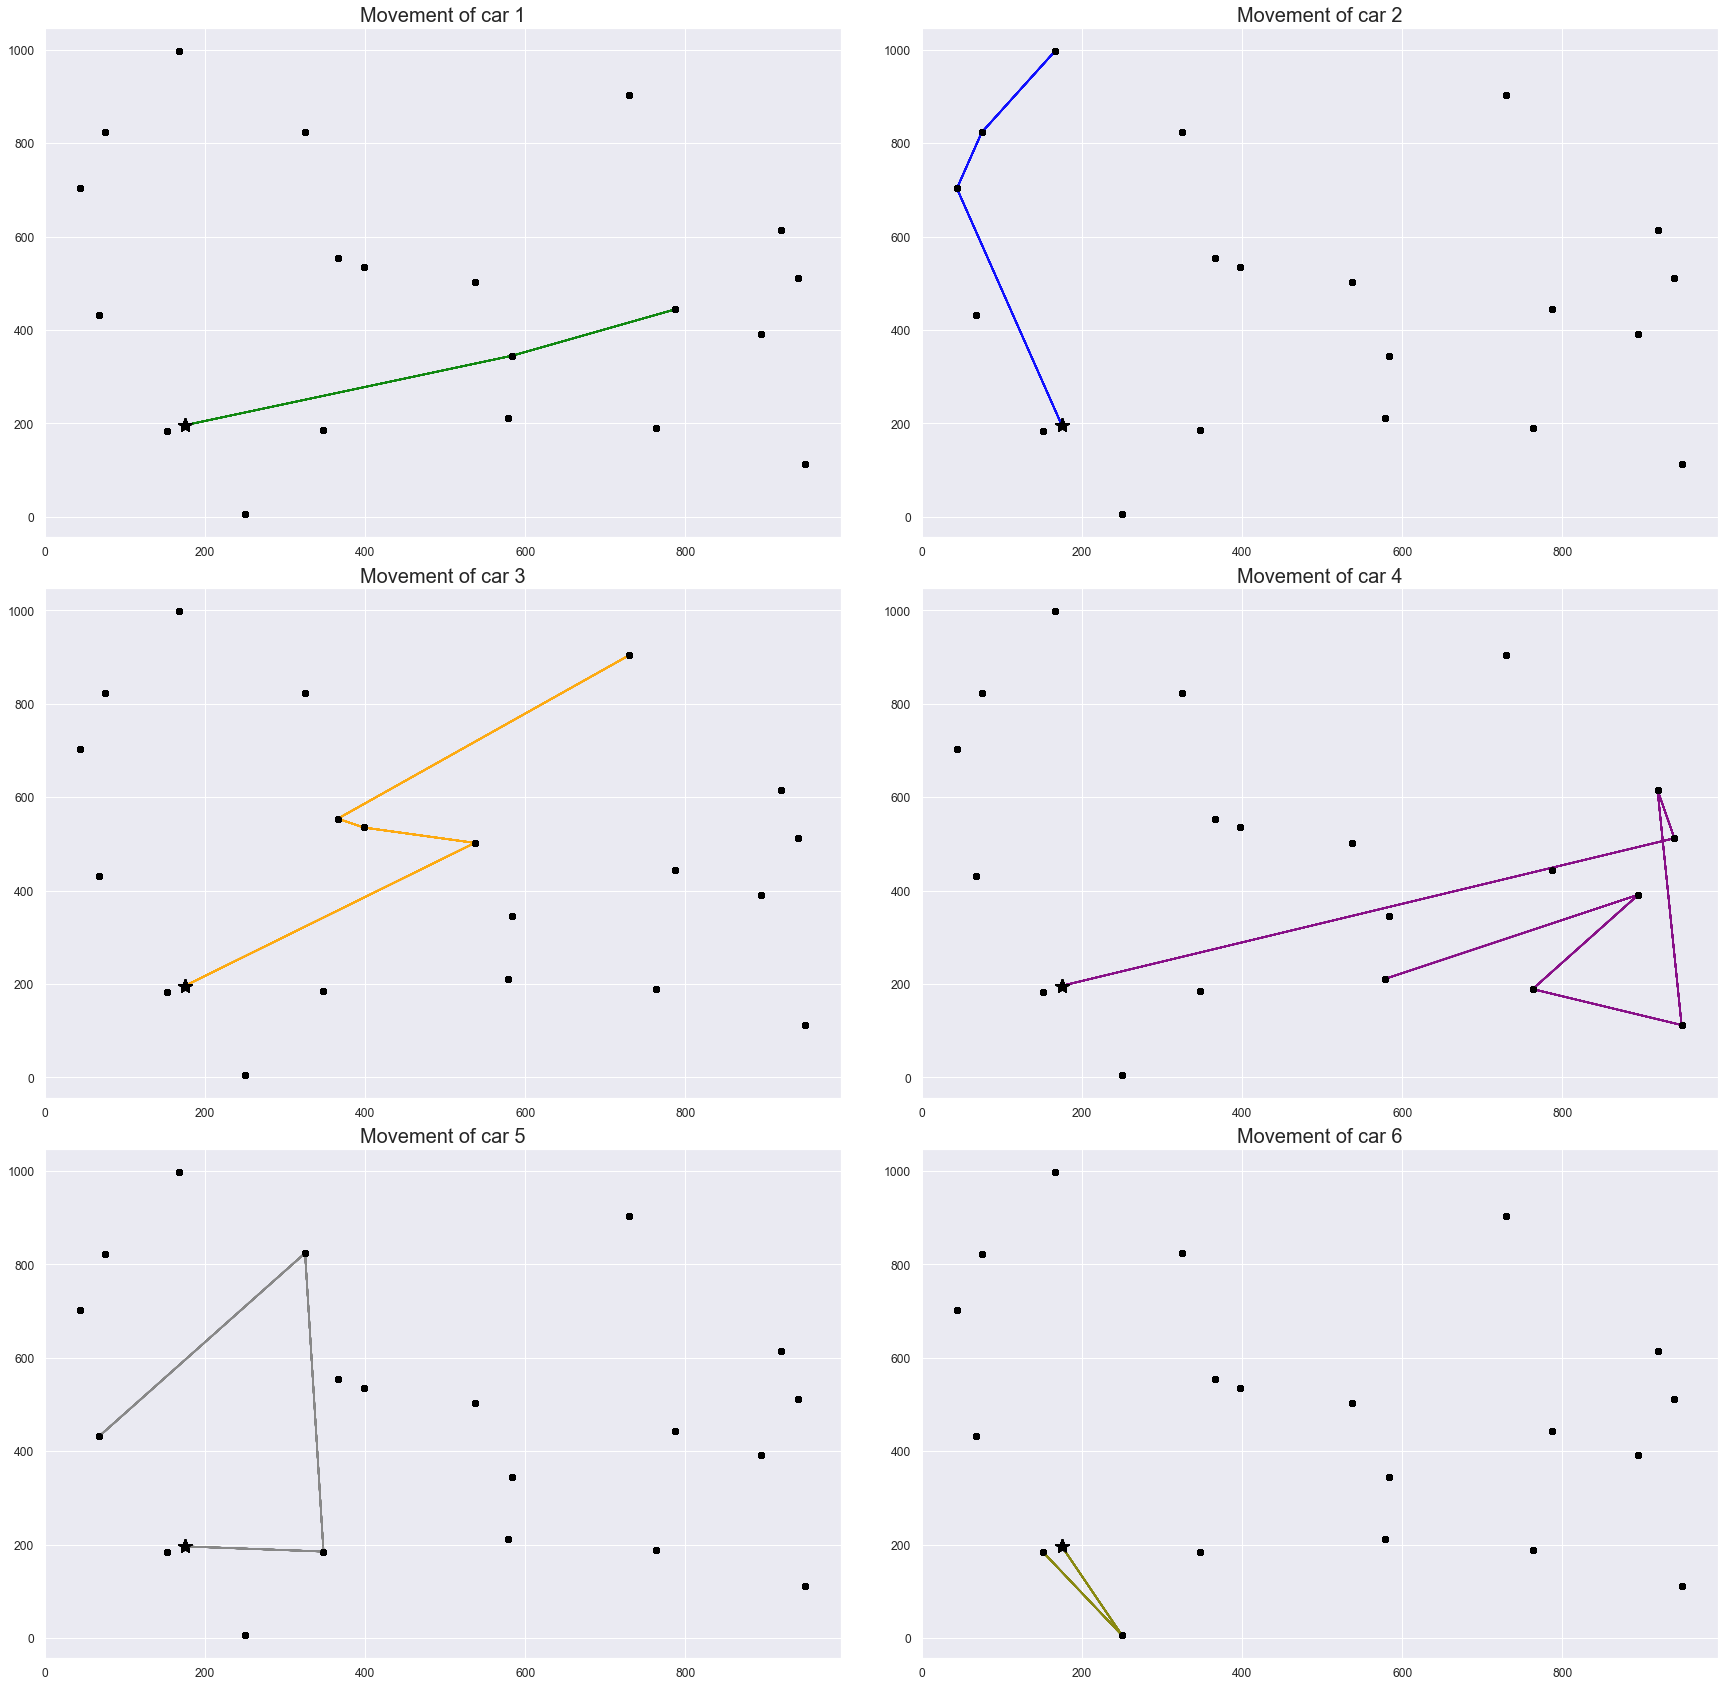

In [36]:
plot_df=week_results.merge(df, on='Destination')
fig = plt.figure(figsize=(30, 30))
axs = fig.subplots(3, 2, gridspec_kw={'hspace': .1, 'wspace': .1})
for week in range(0, Time_horizon):
    # Filter data for the week
    df_filter=plot_df.loc[plot_df['Week']==16]
    # plot car 1
    travel_plot(a=0,b=0,color="green",car=1)
    # plot car 2
    travel_plot(a=0,b=1,color="blue",car=2)
    # plot car 3
    travel_plot(a=1,b=0,color="orange",car=3)
    # plot car 4
    travel_plot(a=1,b=1,color="purple",car=4)
    # plot car 5
    travel_plot(a=2,b=0,color="grey",car=5)
    # plot car 6
    travel_plot(a=2,b=1,color="olive",car=6)
plt.savefig(r"Delivery_route.png")
plt.show()    

#### 3.3. Deliveries

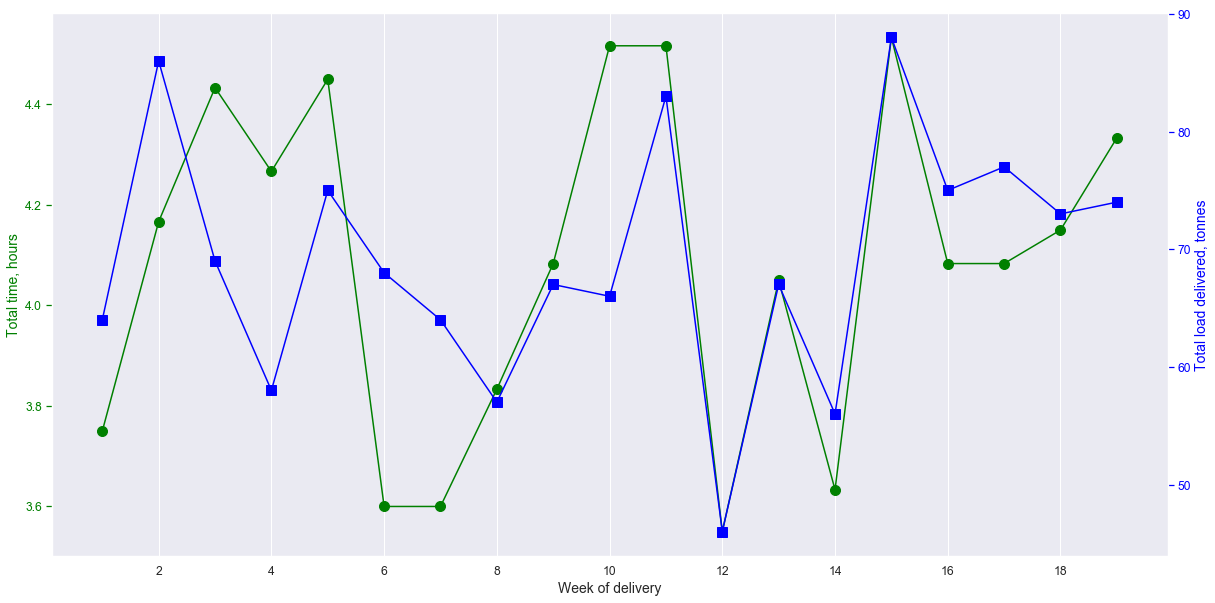

In [37]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize=(20, 10))

# Time plot
ax.plot(deliveries.Week, deliveries.Time/60, color="green", marker="o",markersize=10)
ax.set_xlabel("Week of delivery", fontsize=14)
ax.set_ylabel("Total time, hours", color="green", fontsize=14, )
ax.grid(False)
ax.xaxis.grid()
ax.tick_params(axis='y', colors="green")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# Load plot
ax2=ax.twinx()
ax2.plot(deliveries.Week, deliveries.Load, color="blue", marker="s",markersize=10)
ax2.set_ylabel("Total load delivered, tonnes", color="blue", fontsize=14)
ax2.grid(False)
ax2.tick_params(axis='y', colors="blue")

plt.savefig(r"Time and load capacity.png")
plt.show()